In [1]:
import numpy as np
import datasets
import torch
from torcheval.metrics import BinaryAUROC
import transformers
import matplotlib.pyplot as plt
import wandb

CUDA_JOB_NUM = 1
cuda_model = f"cuda:{CUDA_JOB_NUM}"

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = datasets.load_from_disk("ms_marco")

ds

DatasetDict({
    validation: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 101093
    })
    train: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 808731
    })
    test: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 101092
    })
})

In [3]:
ds['train'][0:10]

{'answers': [['The immediate impact of the success of the manhattan project was the only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.'],
  ['Restorative justice that fosters dialogue between victim and offender has shown the highest rates of victim satisfaction and offender accountability.'],
  ['The reasons why Stalin wanted to control Eastern Europe are Russia has historically no secure border and they wanted to set up satellite countries.'],
  ['Nails rust in water because water allows the iron to react with any oxygen present, which forms iron oxide. Nails rust due to presence of some impurities in the water, particularly salts, which speeds up the transfer of electrons from iron to oxygen.'],
  ['Depona Ab is a library in Vilhelmina, Sweden.'],
  ['No Answer Present.'],
  ['$43,746 for the 2014-2015 academic year.'],
  ['Before the age of 2–4 years.'],
 

In [4]:
from transformers import BertModel, AutoTokenizer, BertConfig

class CrossEncoder(torch.nn.Module):
    def __init__(self, model_name):
        super(CrossEncoder, self).__init__()
        config = BertConfig.from_pretrained(model_name)
        self.bert = BertModel.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.linear_layer1 = torch.nn.Linear(config.hidden_size, 300)
        self.linear_layer2 = torch.nn.Linear(300, 50)
        self.classifier_layer = torch.nn.Linear(50, 1)
    
    def forward(self, input_ids, attention_mask):
        logits = self.bert(input_ids, attention_mask).pooler_output
        logits = torch.relu(self.linear_layer1(logits))
        logits = torch.relu(self.linear_layer2(logits))
        logits = self.classifier_layer(logits)

        return torch.sigmoid(logits)

    def to(self, device):
        self.bert.to(device)
        self.linear_layer1.to(device)
        self.linear_layer2.to(device)
        self.classifier_layer.to(device)
        return self


In [5]:
def flatten(preds, labels):
    final_preds = []
    final_labels = []
    for pred, label in zip(preds, labels):
        final_preds.extend(pred)
        final_labels.extend(label)
    return np.array(final_preds), np.array(final_labels)

def accuracy(preds, labels, flatten=True):
    if flatten:
        preds, labels = flatten(preds, labels)
    accuracy = ((np.array(preds) > 0.5).astype(int) == np.array(labels)).mean()
    return accuracy

def roc_auc(preds, labels, flatten=True):
    if flatten:
        preds, labels = flatten(preds, labels)
    roc_auc = BinaryAUROC(num_tasks=1)
    roc_auc.update(torch.tensor(preds), torch.tensor(labels))
    return roc_auc.compute()

def precision(preds, labels, flatten=True):
    if flatten:
        preds, labels = flatten(preds, labels)
    true_positives = sum(preds[labels == 1] > 0.5)
    false_positives = sum(preds[labels == 0] > 0.5)
    return true_positives / (true_positives + false_positives)

def rank_score(preds, labels):
    average_rank = 0
    count = 0
    for i in range(len(preds)):
        preds_sorted_rank = np.argsort(np.argsort(preds[i])[::-1])
        if len(preds_sorted_rank[labels[i] == 1]) > 0:
            average_rank += np.mean(preds_sorted_rank[labels[i] == 1])
            count += 1
    return average_rank / count


In [6]:
model = CrossEncoder("google-bert/bert-base-uncased")
model.to(cuda_model)

CrossEncoder(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [180]:
k = 0
count = 0
for i in range(20000):
    k += sum(ds['train'][i]['passages']['is_selected'])
    count += len(ds['train'][i]['passages']['is_selected'])
k / count

0.06528996040298732

In [6]:
def predict(model, batch_data):
  final_preds = []
  final_labels = []
  with torch.no_grad():
    for i in range(len(batch_data)):
        data = batch_data[i]
        tokens = model.tokenizer(
            text=[data['query']] * len(data['passages']['passage_text']),
            text_pair=data['passages']['passage_text'],
            return_tensors='pt',
            padding=True,
            truncation=True
        ).to(cuda_model)

        
        with torch.amp.autocast(cuda_model):  # Mixed precision
            preds = model(tokens.input_ids, tokens.attention_mask).detach().cpu()
        
        final_labels.append(np.array(data['passages']['is_selected']))
        final_preds.append(preds.numpy().reshape(-1))

        del tokens
        torch.cuda.empty_cache()
  
  return final_preds, final_labels

In [18]:
def bad_rank_score(preds, labels):
    average_rank = 0
    count = 0
    for i in range(len(preds)):
        preds_sorted_rank = np.argsort(np.argsort(preds[i])[::-1])
        if len(preds_sorted_rank[labels[i] == 1]) > 0:
            average_rank += np.mean(preds_sorted_rank[labels[i] == 1])
            count += 1
    return average_rank / len(preds)

In [19]:
preds, labels = predict(model, ds['validation'].select(range(1000)))
# torch.nn.functional.binary_cross_entropy(torch.tensor(preds).float().reshape(1, -1), torch.tensor(labels).float().reshape(1, -1)) 
# print(roc_auc(preds, labels))
print(rank_score(preds, labels))
print(bad_rank_score(preds, labels))

3.1154708520179373
1.3895


In [9]:
np.mean([len(label) for label in labels]), np.mean([sum(label) for label in labels if sum(label) > 0])

(np.float64(9.992), np.float64(1.066334991708126))

In [10]:
print(rank_score(labels, labels))

0.03316749585406302


In [9]:
model = CrossEncoder("google-bert/bert-base-uncased")
model.to(cuda_model)

config = {
    "epochs": 10,
    "num_samples": 3000,
    "learning_rate": 6e-5,
    "weight_decay": 0.005,
    "momentum": 0.9,
    "model": "google-bert/bert-base-uncased"
}

wandb.init(project="exa_reranker", config=config)


optimizer = torch.optim.SGD(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"], momentum=config["momentum"])

train_eval = {
    "losses": [],
    "roc_aucs": [],
    "accuracies": [],
    "precisions": [],
    "rank_scores": []
}

validation_eval = {
    "losses": [],
    "roc_aucs": [],
    "accuracies": [],
    "precisions": [],
    "rank_scores": []
}

epochs = config["epochs"]
num_samples = config["num_samples"]

for epoch in range(epochs):
    print(f"Epoch {epoch}")
    for i in range(num_samples):
        if i % (num_samples // 10) == 0:
            print(i)
        
        optimizer.zero_grad()
        data = ds['train'][i]

        tokens = model.tokenizer(
            text=[data['query']] * len(data['passages']['passage_text']),
            text_pair=data['passages']['passage_text'],
            return_tensors='pt',
            padding=True
        ).to(cuda_model)
        
        preds = model(tokens.input_ids, tokens.attention_mask)
        labels = torch.tensor(data['passages']['is_selected']).float().to(cuda_model)

        positive_examples = preds[labels.squeeze() == 1]
        negative_examples = preds[labels.squeeze() == 0]

        for positive_example in positive_examples:
            if len(negative_examples) == 0:
                continue
            indices = np.random.choice(len(negative_examples), size=3, replace=False)
            for idx in indices:
                negative_example = negative_examples[idx]
                # Compute the loss for the positive-negative pair
                loss = torch.nn.functional.binary_cross_entropy(
                    torch.cat((positive_example, negative_example), dim=0),
                    torch.tensor([1.0, 0.0]).to(cuda_model)
                )
                loss.backward(retain_graph=True)
        
        optimizer.step()
        
        del tokens
        del preds
        del labels
        torch.cuda.empty_cache()
    
    num_to_eval = 1000
    preds_train, labels_train = predict(model, ds['train'].select(range(num_to_eval)))
    preds_train_flat, labels_train_flat = flatten(preds_train, labels_train)
    train_eval["losses"].append(torch.nn.functional.binary_cross_entropy(torch.tensor(preds_train_flat).float().reshape(1, -1), torch.tensor(labels_train_flat).float().reshape(1, -1)).item())
    train_eval["roc_aucs"].append(roc_auc(preds_train_flat, labels_train_flat, flatten=False))
    train_eval["accuracies"].append(accuracy(preds_train_flat, labels_train_flat, flatten=False))
    train_eval["precisions"].append(precision(preds_train_flat, labels_train_flat, flatten=False))
    train_eval["rank_scores"].append(rank_score(preds_train, labels_train))

    print(f"Training Stats - ROC AUC: {train_eval['roc_aucs'][-1]}, Accuracy: {train_eval['accuracies'][-1]}, Precision: {train_eval['precisions'][-1]}, Rank Score: {train_eval['rank_scores'][-1]}")
    
    preds, labels = predict(model, ds['validation'].shuffle(seed=42).select(range(num_to_eval)))
    preds_flat, labels_flat = flatten(preds, labels)
    validation_eval["losses"].append(torch.nn.functional.binary_cross_entropy(torch.tensor(preds_flat).float().reshape(1, -1), torch.tensor(labels_flat).float().reshape(1, -1)).item())
    validation_eval["roc_aucs"].append(roc_auc(preds_flat, labels_flat, flatten=False))
    validation_eval["accuracies"].append(accuracy(preds_flat, labels_flat, flatten=False))
    validation_eval["precisions"].append(precision(preds_flat, labels_flat, flatten=False))
    validation_eval["rank_scores"].append(rank_score(preds, labels))
    
    print(f"Validation Stats - ROC AUC: {validation_eval['roc_aucs'][-1]}, Accuracy: {validation_eval['accuracies'][-1]}, Precision: {validation_eval['precisions'][-1]}, Rank Score: {validation_eval['rank_scores'][-1]}")
    
    wandb.log({
        "epoch": epoch,
        "train_roc_auc": train_eval["roc_aucs"][-1],
        "train_accuracy": train_eval["accuracies"][-1],
        "train_precision": train_eval["precisions"][-1],
        "train_rank_score": train_eval["rank_scores"][-1],
        "train_loss": train_eval["losses"][-1],
        "validation_roc_auc": validation_eval["roc_aucs"][-1],
        "validation_accuracy": validation_eval["accuracies"][-1],
        "validation_precision": validation_eval["precisions"][-1],
        "validation_rank_score": validation_eval["rank_scores"][-1],
        "validation_loss": validation_eval["losses"][-1]
    })

    torch.save(model.state_dict(), f"model_contrastive_3000_{epoch}.pth")

wandb.finish()


epoch,▁▂▄▅▇█
train_accuracy,▅▇▇█▄▁
train_loss,▅▃▃▁▆█
train_precision,▃▅▅█▃▁
train_rank_score,█▅▄▁▂▆
train_roc_auc,▁▄▆█▇▅
validation_accuracy,▅▇▇█▄▁
validation_loss,▄▃▃▁▆█
validation_precision,▃▇▆█▃▁
validation_rank_score,▆▂▂▁▂█
validation_roc_auc,▁▆▇█▆▁


Epoch 0
0
300
600
900
1200
1500
1800
2100
2400
2700
Training Stats - ROC AUC: 0.6249236659570713, Accuracy: 0.5447357886309048, Precision: 0.08832209106239461, Rank Score: 3.1885019347705916
Validation Stats - ROC AUC: 0.6322620976864228, Accuracy: 0.597177742193755, Precision: 0.08393632416787265, Rank Score: 3.0948434622467773
Epoch 1
0
300
600
900
1200
1500
1800
2100
2400
2700
Training Stats - ROC AUC: 0.7064296262089724, Accuracy: 0.7115692554043235, Precision: 0.12037978975924042, Rank Score: 2.5681315644002214
Validation Stats - ROC AUC: 0.6940280067038797, Accuracy: 0.747097678142514, Precision: 0.11514195583596215, Rank Score: 2.6387354205033766
Epoch 2
0
300
600
900
1200
1500
1800
2100
2400
2700
Training Stats - ROC AUC: 0.77493729837291, Accuracy: 0.7419935948759008, Precision: 0.1503433321286592, Rank Score: 2.013266998341625
Validation Stats - ROC AUC: 0.7362986458347761, Accuracy: 0.7563050440352281, Precision: 0.12317666126418152, Rank Score: 2.321669736034377
Epoch 3
0
3

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▅▃▆▇██
train_loss,█▇▆▅▅▇▄▂▁▁
train_precision,▁▂▂▃▃▃▄▆██
train_rank_score,█▇▅▄▃▃▂▁▁▁
train_roc_auc,▁▃▄▅▆▆▇▇██
validation_accuracy,▁▅▅▆▄▂▅▇██
validation_loss,█▆▅▄▅▇▄▂▁▁
validation_precision,▁▃▄▅▄▃▅▆██
validation_rank_score,█▅▂▂▁▁▁▂▁▁
validation_roc_auc,▁▄▇████▇██


In [11]:
model = CrossEncoder("google-bert/bert-base-uncased")
model.load_state_dict(torch.load("model_contrastive_3000_9.pth"))
model.to(cuda_model)
preds, labels = predict(model, ds['validation'].select(range(1000)))
print(rank_score(preds, labels))

/tmp/ipykernel_132285/228980569.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_contrastive_3000_9.pth"))


2.4902840059790727


In [14]:
def strict_rank_score(preds, labels, threshold = 1):
    num_in_ones = 0
    count = 0
    for i in range(len(preds)):
        preds_sorted_rank = np.argsort(np.argsort(preds[i])[::-1])
        if len(preds_sorted_rank[labels[i] == 1]) > 0:
            average_rank = np.mean(preds_sorted_rank[labels[i] == 1])
            if average_rank < threshold:
                num_in_ones += 1
            count += 1
    return num_in_ones / count

In [16]:
strict_rank_score(preds, labels, 1), strict_rank_score(preds, labels, 2), strict_rank_score(preds, labels, 3), strict_rank_score(preds, labels, 4)

(0.26905829596412556,
 0.4439461883408072,
 0.594170403587444,
 0.7040358744394619)

In [ ]:
wandb.finish()

In [18]:
torch.sigmoid(torch.tensor(preds_train_flat)).float().reshape(1, -1)

tensor([[0.4709, 0.4634, 0.4648,  ..., 0.4734, 0.4656, 0.4658]])

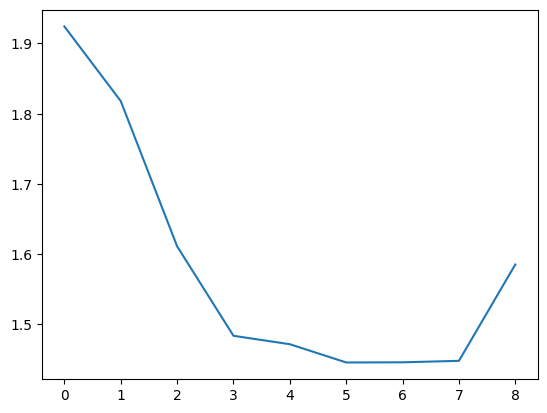

In [176]:
plt.plot(rank_scores)

In [11]:
len(losses)

150000

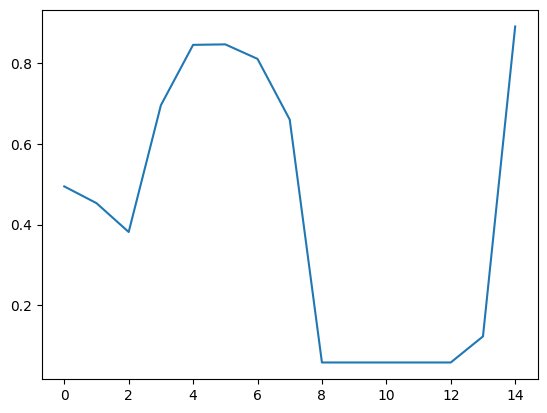

In [13]:
plt.plot(val_accuracies)

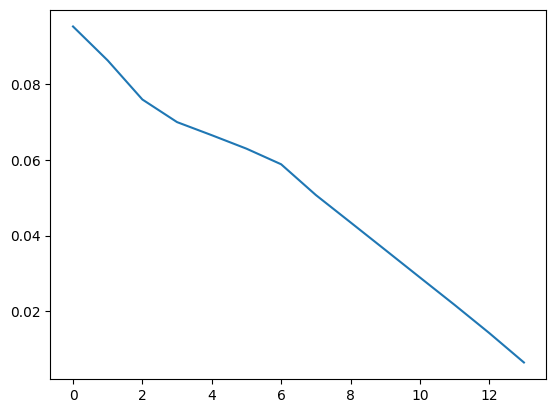

In [17]:
# plt.plot(losses[1500:1800])
# plt.plot(losses[100:2000])
# plt.plot(losses)
k = 100
plt.plot(np.convolve(val_losses, np.ones(k) / k)[k:])

In [79]:
preds, labels = predict(model, ds['validation'].select(range(1000)))
print(f"ROC AUC: {roc_auc(preds, labels)}, Accuracy: {accuracy(preds, labels)}, Precision: {precision(preds, labels)}")

/tmp/ipykernel_127774/3070306796.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision


0.4979253112033195 0.12061519014010323
ROC AUC: 0.8120909576088605, Accuracy: 0.8609523809523809, Precision: 0.17328519855595667


In [44]:
tokens = model.tokenizer(text=ds['train'][0]['query'], text_pair=ds['train'][0]['passages']['passage_text'][5], return_tensors='pt', padding=True).to(cuda_model)
print(tokens)
model(tokens.input_ids, tokens.attention_mask)

{'input_ids': tensor([[  101,  1007,  2054,  2001,  1996,  6234,  4254,  1997,  1996,  3112,
          1997,  1996,  7128,  2622,  1029,   102,  1996,  7128,  2622,  1012,
          2023,  2320,  6219,  9982,  2838,  1996,  2034,  9593,  5968,  1517,
          1037,  5195,  2008,  9593,  6529,  2018,  9919, 11721, 24291,  1012,
          1012,  1996,  4517,  2287,  2211,  2006,  2251,  2385,  1010,  3386,
          1010,  2043,  2009,  2001, 28110,  1999,  1996,  2047,  3290,  5532,
          1012,   102]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

tensor([[-1.4949]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [51]:
ds['train'][1]

{'answers': ['Restorative justice that fosters dialogue between victim and offender has shown the highest rates of victim satisfaction and offender accountability.'],
 'passages': {'is_selected': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
  'passage_text': ['group discussions, community boards or panels with a third party, or victim and offender dialogues, and requires a skilled facilitator who also has sufficient understanding of sexual assault, domestic violence, and dating violence, as well as trauma and safety issues.',
   "punishment designed to repair the damage done to the victim and community by an offender's criminal act. Ex: community service, Big Brother program indeterminate sentence",
   'Tutorial: Introduction to Restorative Justice. Restorative justice is a theory of justice that emphasizes repairing the harm caused by criminal behaviour. It is best accomplished through cooperative processes that include all stakeholders. This can lead to transformation of people, relationships and

In [11]:
torch.cuda.empty_cache()